# Netflix Content Strategy Analysis

**Author:** Armel Stéphane Novak KI  
**Context:** This project is a comprehensive refactoring of an initial exploratory analysis. My goal is to apply advanced data cleaning techniques and professional visualizations to uncover insights about Netflix's content strategy.

### Objectives
1.  **Data Cleaning:** Handle missing values intelligently (imputation vs dropping).
2.  **Feature Engineering:** Extract meaningful temporal data and parse durations.
3.  **Visualization:** Analyze the ratio of Movies vs TV Shows, geographical distribution, and content growth.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
NETFLIX_PALETTE = ['#e50914', '#221f1f']  # Netflix Brand Colors

# Load Data
try:
    df = pd.read_csv('../data/netflix_titles.csv')
    print(f"Data loaded successfully. Shape: {df.shape}")
except FileNotFoundError:
    print("Error: File not found. Please check the path.")

df.head(3)

Data loaded successfully. Shape: (8807, 12)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


## 1. Data Cleaning & Preprocessing

My strategy focuses on preserving data integrity:
* **Directors/Cast/Country:** Missing values are replaced with "Unknown" to avoid data loss during categorical analysis.
* **Dates:** Rows with missing dates are dropped (negligible quantity).
* **Types:** Converted dates to `datetime` objects for time-series analysis.

In [3]:
# 1. Handling Missing Values
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')
df['country'] = df['country'].fillna('Unknown')

# Drop rows with critical missing data (dates, rating)
df.dropna(subset=['date_added', 'rating', 'duration'], inplace=True)

# 2. Type Conversion & Feature Engineering
# Convert date_added to datetime
df['date_added'] = pd.to_datetime(df['date_added'].str.strip(), errors='coerce')

# Extract Year and Month
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month_name()

print(f"Cleaning complete. Rows remaining: {df.shape[0]}")
print(f"   Missing values left: {df.isnull().sum().sum()}")

Cleaning complete. Rows remaining: 8790
   Missing values left: 0


## 2. Exploratory Data Analysis (EDA)

### 2.1 Content Distribution: Movies vs TV Shows
Is Netflix shifting its focus towards TV Shows? Let's look at the global library composition.

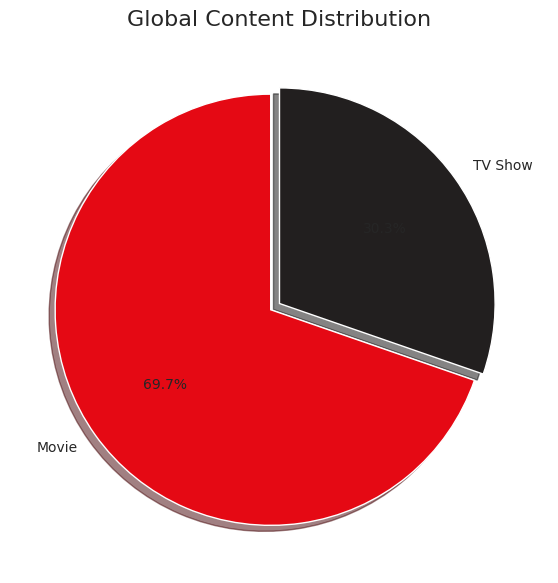

In [4]:
plt.figure(figsize=(7, 7))
df['type'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=NETFLIX_PALETTE,
    explode=[0.05, 0],
    shadow=True
)
plt.title('Global Content Distribution', fontsize=16)
plt.ylabel('')
plt.show()

### 2.2 Content Growth Over Time
How has the rate of content addition evolved over the years?

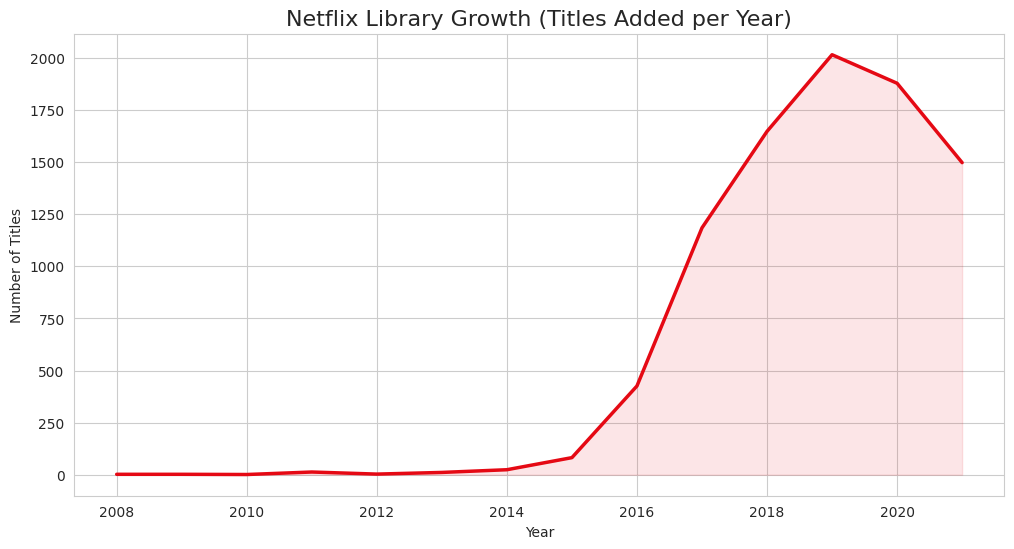

In [4]:
content_by_year = df['year_added'].value_counts().sort_index()

# Filter to remove potential incomplete future data or errors
valid_years = content_by_year[content_by_year.index < 2024]

plt.figure(figsize=(12, 6))
sns.lineplot(x=valid_years.index, y=valid_years.values, color='#e50914', linewidth=2.5)
plt.fill_between(valid_years.index, valid_years.values, color='#e50914', alpha=0.1)

plt.title('Netflix Library Growth (Titles Added per Year)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.show()

### 2.3 Top Producing Countries
Which countries produce the most content?
*Note: I handled multi-country productions (e.g., "USA, UK") by splitting the data to count each country individually.*

/tmp/ipykernel_99493/1949277227.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='Reds_r')


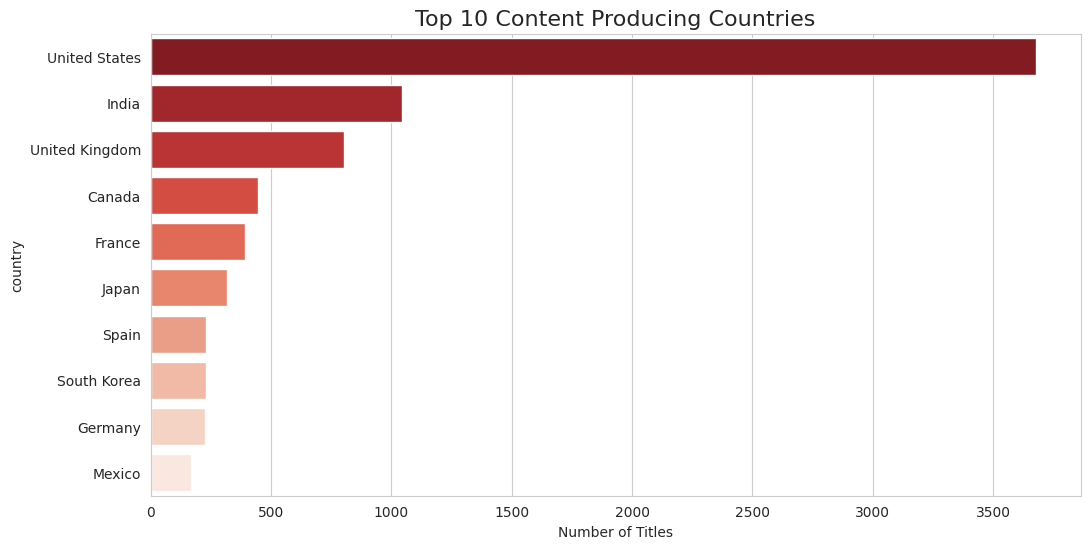

In [5]:
# Split countries separated by commas and explode them into new rows
countries = df['country'].str.split(', ').explode()

# Remove 'Unknown' and get top 10
top_countries = countries[countries != 'Unknown'].value_counts().head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='Reds_r')
plt.title('Top 10 Content Producing Countries', fontsize=16)
plt.xlabel('Number of Titles')
plt.show()

### 2.4 Movie Duration Distribution
What is the standard length of a movie on Netflix?

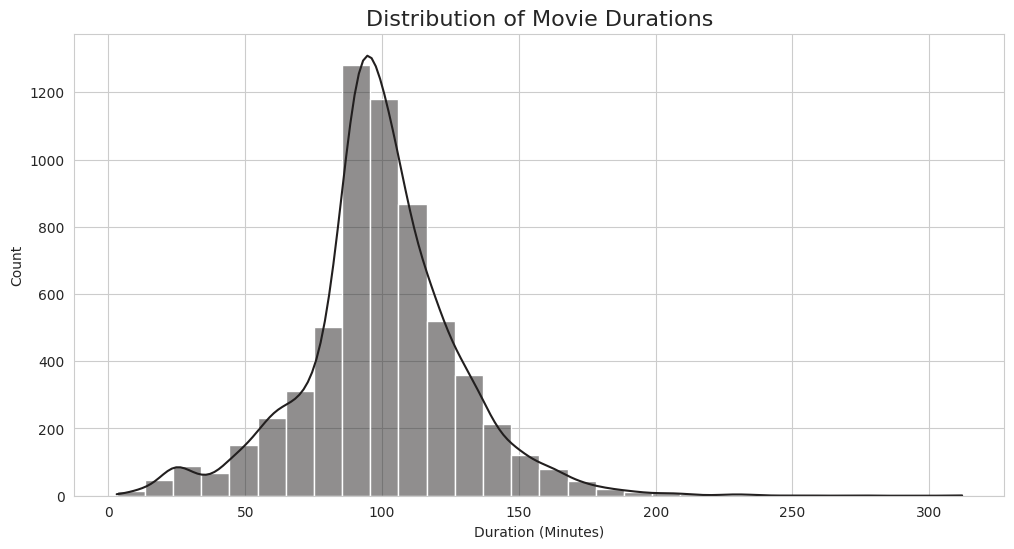

In [6]:
# Filter Movies only
movies = df[df['type'] == 'Movie'].copy()

# Clean duration column ("90 min" -> 90)
movies['duration_min'] = movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(12, 6))
sns.histplot(movies['duration_min'], bins=30, kde=True, color='#221f1f')
plt.title('Distribution of Movie Durations', fontsize=16)
plt.xlabel('Duration (Minutes)')
plt.show()